In [1]:
import os 
os.chdir("..")

In [2]:
import numpy as np
import torch
import matplotlib
from tqdm import tqdm
from matplotlib import rc

# Set the font dictionaries (for correct font properties)
matplotlib.rcParams['font.serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.sans-serif'] = "Helvetica"
matplotlib.rcParams['axes.labelsize'] = 11
matplotlib.rcParams['font.size'] = 11
rc('text', usetex=True)

import matplotlib.pyplot as plt

In [3]:
from main import train_single_model_from_config
from utils.setup import load_data_module
import yaml

{'a/b/c': 1, 'a/b/d': 2, 'a/e': 3, 'f': 4}


2024-04-20 13:17:34.503570: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-20 13:17:34.503625: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-20 13:17:34.595991: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


KeyboardInterrupt: 

## Single Seed

In [ ]:
config_file = "configs/notebook_configs/config_mdn_full_recalibration.yml"
with open(config_file, "r") as f:
    config = yaml.safe_load(f)

In [ ]:
dm = load_data_module(**config["data_hyperparameters"])

In [ ]:
model = train_single_model_from_config(config_file)

val_nll_loss: 2.4914909811580883, train-loss: 0.43722328543663025:  11%|█         | 53/500 [00:22<03:07,  2.38it/s] 

Epoch 00053: reducing learning rate of group 0 to 1.0000e-04.


val_nll_loss: 2.4586875952926337, train-loss: -0.06286537647247314:  13%|█▎        | 67/500 [00:27<02:57,  2.44it/s]

Epoch 00067: reducing learning rate of group 0 to 5.0000e-05.


val_nll_loss: 2.4625133626601277, train-loss: 0.2608163058757782:  14%|█▍        | 70/500 [00:29<03:02,  2.36it/s]  

Early stopping


In [93]:
k = 256
y_grid_size = 2**13
confidence_grid = torch.linspace(1/k, 1 - 1/k, k)
y_space = model.y_space
y_space = torch.linspace(y_space.min().item() - model.std_y.item(), y_space.max().item() + model.std_y.item(), y_grid_size)
scaling_factor = ((y_space.max() - y_space.min())/len(y_space))**-1

In [94]:
scaling_factor

tensor(114.2024)

In [95]:
required_ps = []
with torch.no_grad():
    for x, y in tqdm(dm.get_train_dataloader(64)):

        x = x.to("cuda")
        y = y.to("cuda")

        required_p = model.get_required_conformal_p_values(x, y, torch.tensor(y_space, device="cuda"))
        del x, y
        required_ps.append(required_p)
required_ps = torch.cat(required_ps, 0)

  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_2166138/3093232464.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  required_p = model.get_required_conformal_p_values(x, y, torch.tensor(y_space, device="cuda"))
100%|██████████| 7/7 [00:00<00:00,  8.51it/s]


In [96]:
required_ps = required_ps.cpu()

In [97]:
calibrated_confidence_grid = torch.quantile(required_ps.float(), confidence_grid)

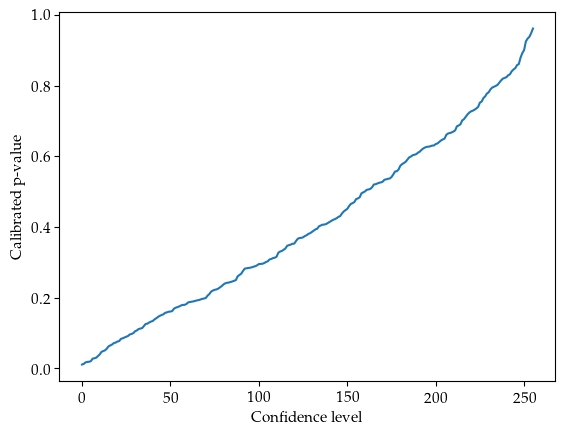

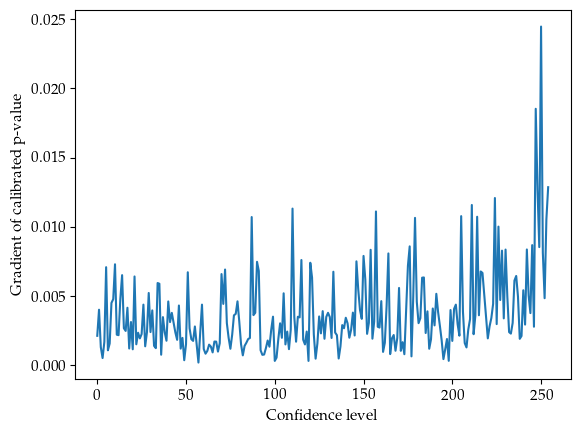

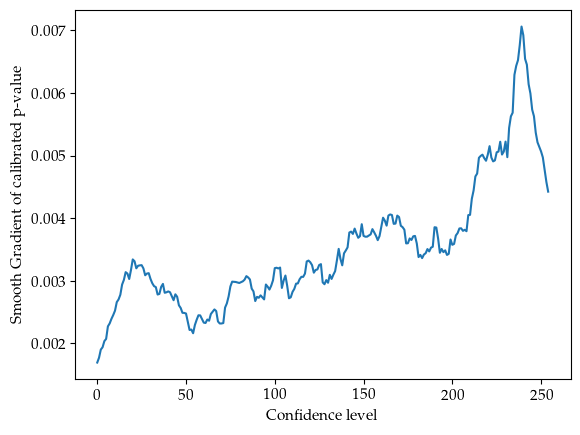

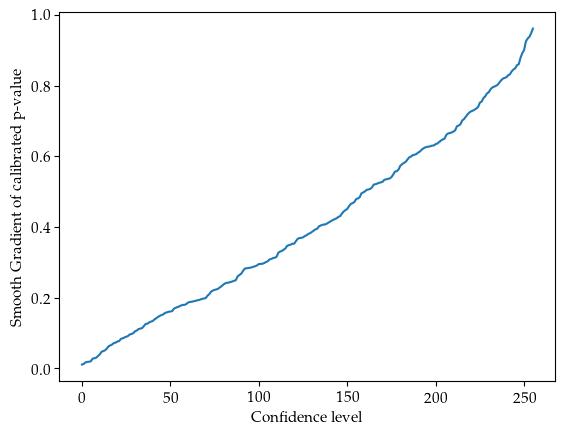

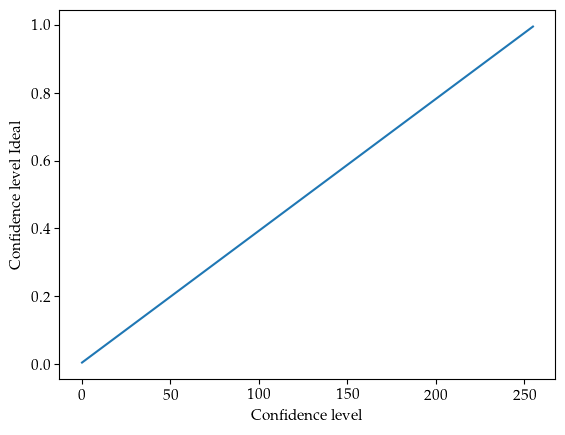

In [98]:
%matplotlib inline
plt.plot(calibrated_confidence_grid.detach().numpy())
plt.xlabel("Confidence level")
plt.ylabel("Calibrated p-value")
plt.show()


grad = calibrated_confidence_grid[1:] - calibrated_confidence_grid[:-1]
plt.plot(grad.detach().numpy())
plt.xlabel("Confidence level")
plt.ylabel("Gradient of calibrated p-value")
plt.show()

window_size = k//8
filter_ = np.ones(window_size) / window_size

grad_grid_smooth = np.convolve(grad, filter_, mode='same')
plt.plot(grad_grid_smooth)
plt.xlabel("Confidence level")
plt.ylabel("Smooth Gradient of calibrated p-value")
plt.show()

smooth_calibrated_confidence_grid = np.cumsum(grad_grid_smooth)
smooth_calibrated_confidence_grid /= np.max(smooth_calibrated_confidence_grid)
smooth_calibrated_confidence_grid -= 1/k
plt.plot(calibrated_confidence_grid)
plt.xlabel("Confidence level")
plt.ylabel("Smooth Gradient of calibrated p-value")
plt.show()
#calibrated_confidence_grid = torch.tensor(smooth_calibrated_confidence_grid)

plt.plot(confidence_grid.detach().numpy())
plt.xlabel("Confidence level")
plt.ylabel("Confidence level Ideal")
plt.show()

In [99]:
model = model.cuda()

In [100]:
scaling_factor = scaling_factor.cpu()

In [101]:
do_plot = True

In [137]:
ll_before = []
ll_after = []
ll_before_original = []
ll_maxim = []
with torch.no_grad():
    for x, y in tqdm(dm.get_test_dataloader(64)):


        x = x.to("cuda")

        hdr_before = model.get_hdr(x, confidence_grid.cuda(), torch.tensor(y_space).cuda())
        hdr_after = model.get_hdr(x, calibrated_confidence_grid.cuda(), torch.tensor(y_space).cuda())
        density_grid = model.get_density_grid(x, torch.tensor(y_space).cuda())

        hdr_before = hdr_before.cpu()
        hdr_after = hdr_after.cpu()
        density_grid = density_grid.cpu()

        if do_plot: fig, axs = plt.subplots(2, 2, figsize=(12, 8))

        for sample_no in range(len(hdr_before)):
            before, after = hdr_before[sample_no].clone().detach().numpy(), hdr_after[sample_no].clone().detach().numpy()
            density_grid_before = density_grid[sample_no].clone().detach().numpy()

            before = np.concatenate([before, np.ones_like(before[:1])], 0)
            after = np.concatenate([after, np.ones_like(after[:1])], 0)

            before[1:] =  np.bitwise_xor(before[1:], before[:-1])
            after[1:] =  np.bitwise_xor(after[1:], after[:-1])


            before_grid = np.zeros_like(y_space)
            after_grid = np.zeros_like(y_space)

            #plt.figure(figsize=(8, 6))

            for i in range(before.shape[0]):
                i_sum = np.sum(before[i])
                if i_sum == 0:
                    continue
                level = 1 / i_sum

                active_where = y_space[before[i]]
                before_grid[before[i]] = level
                #plt.scatter(active_where, np.ones_like(active_where) * level, color ="blue", alpha=1- (i / before.shape[0]))

            #plt.legend()
            #plt.show()

            #plt.figure(figsize=(8, 6))

            for i in range(after.shape[0]):
                i_sum = np.sum(after[i])
                if i_sum == 0:
                    continue
                level = 1 / i_sum

                active_where = y_space[after[i]]
                after_grid[after[i]] = level
                #plt.scatter(active_where, np.ones_like(active_where) * level, color ="blue",alpha=1- (i / before.shape[0]))
            #plt.legend()
            #plt.show()

            

            window_size = int(y_grid_size // ( 4 * 2*np.log(len(dm.test_dataset))))

            filter_ = np.ones(window_size) / window_size

            c_before = np.convolve(before_grid, filter_, mode='same')
            c_after = np.convolve(after_grid, filter_, mode='same')
            c_epistemic = np.convolve(np.abs(before_grid - after_grid), filter_, mode='same')

            scaled_before_original = scaling_factor * density_grid_before / np.sum(density_grid_before)
            scaled_before = scaling_factor * c_before / np.sum(c_before)
            scaled_after = scaling_factor * c_after / np.sum(c_after)

            maxim = np.maximum(scaled_before_original, scaled_after)
            scaled_maxim = scaling_factor * maxim / np.sum(maxim.numpy())

            ll_after.append(scaled_after[np.argmin(np.abs(y_space - y[sample_no].numpy()))])
            ll_before.append(scaled_before[np.argmin(np.abs(y_space - y[sample_no].numpy()))])
            ll_before_original.append(scaled_before_original[np.argmin(np.abs(y_space - y[sample_no].numpy()))])
            ll_maxim.append(scaled_maxim[np.argmin(np.abs(y_space - y[sample_no].numpy()))])

            
            if (ll_after[-1] == 0 or ll_before[-1] == 0 or ll_before_original[-1] == 0 or sample_no < 4) and do_plot:




                # Your existing code for plotting
                
                # Calculate the row and column index in the grid
                row = sample_no // 2
                col = sample_no % 2
                
                # Plot the figure in the corresponding subplot
                axs[row, col].plot(y_space, scaled_after, label='After Calibration', color='red', alpha=0.5)
                axs[row, col].plot(y_space, scaled_before_original, label='Before Calibration', color='purple', alpha=0.5)
                axs[row, col].plot(y_space, scaling_factor * c_epistemic/np.sum(c_before), label='Epistemic Uncertainty', color='green')
                axs[row, col].axvline(y[sample_no], color='black', linestyle='--', label='True Target')
                axs[row, col].set_xlabel('target-space')
                axs[row, col].set_ylabel('Density')
                axs[row, col].legend()



                # plt.figure(figsize=(20, 10))
                # #plt.plot(y_space, scaled_before, label='Before Calibration', color='blue', alpha=0.5)
                # #plt.plot(y_space, c_before / np.sum(c_before), label='Before Calibration', color='blue', alpha=0.5)
                # plt.plot(y_space, scaled_after, label='After Calibration', color='red', alpha=0.5)
                # plt.plot(y_space, scaled_before_original, label='Before Calibration', color='purple', alpha=0.5)
                # plt.plot(y_space, scaling_factor * c_epistemic/np.sum(c_before), label='Epistemic Uncertainty', color='green')
                # plt.axvline(y[sample_no], color='black', linestyle='--', label='True Target')
                # plt.xlabel('target-space')
                # plt.ylabel('Density')
                # plt.legend()
                # plt.show()
        if do_plot: 
            plt.tight_layout()
            #plt.suptitle("Calibration of HDRs on Test Data")
            plt.show()

        do_plot = False



  0%|          | 0/2 [00:00<?, ?it/s]

/tmp/ipykernel_2166138/1759927404.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hdr_before = model.get_hdr(x, confidence_grid.cuda(), torch.tensor(y_space).cuda())
/tmp/ipykernel_2166138/1759927404.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hdr_after = model.get_hdr(x, calibrated_confidence_grid.cuda(), torch.tensor(y_space).cuda())
/tmp/ipykernel_2166138/1759927404.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  density_grid = model.get_density_grid(x, torch.tensor(y_space).cuda())
100%|██████████| 2/2 [00:04<00:00,

In [138]:
window_size, ( 8 * 2*np.log(len(dm.test_dataset)))

(221, 73.99956501254833)

In [139]:
np.log(ll_before_original).mean()

-2.4494662

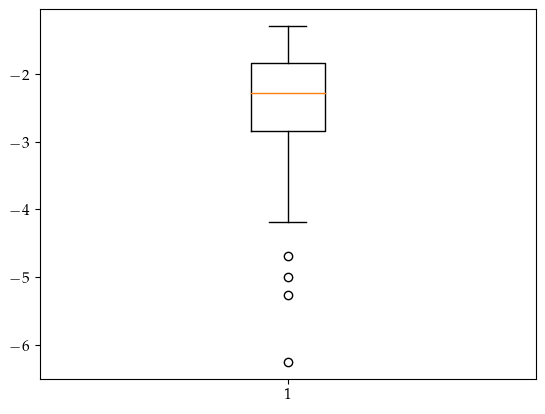

In [140]:
plt.boxplot(np.log(ll_before_original))
plt.show()

In [141]:
np.log(ll_before).mean()

-2.4562443322771577

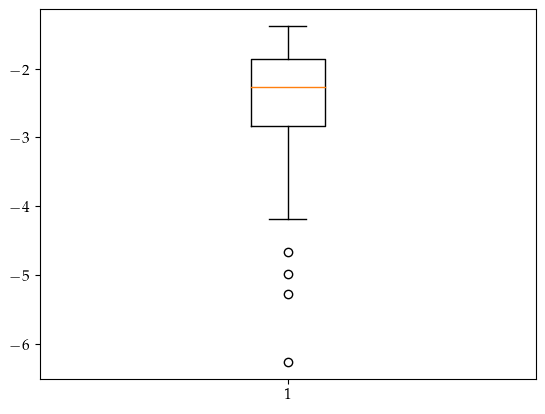

In [142]:
plt.boxplot(np.log(ll_before))
plt.show()

In [143]:
np.log(ll_after).mean()

-2.4167859842629666

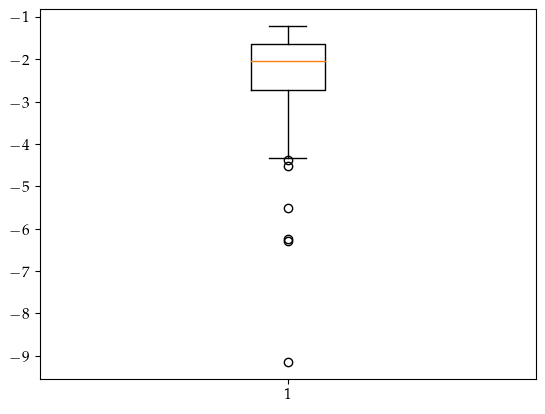

In [144]:
plt.boxplot(np.log(ll_after))
plt.show()

In [145]:
np.log(ll_maxim).mean()

-2.4412912898597563

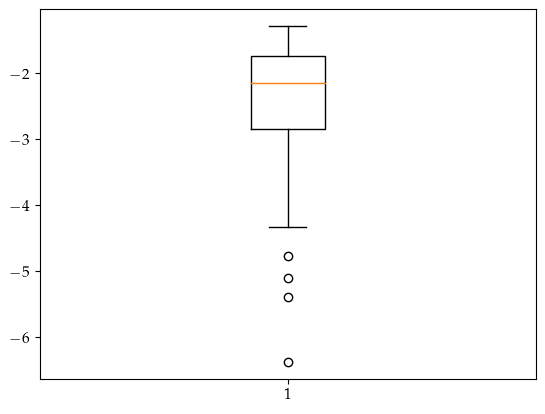

In [146]:
plt.boxplot(np.log(ll_maxim))
plt.show()

## Do this with multiple seeds and datasets

In [4]:
do_plot = False

In [5]:
window_sizes = np.arange(1, 20, 1)

In [7]:
config_file = "configs/notebook_configs/config_kmn_full_recalibration.yml"
with open(config_file, "r") as f:
    config = yaml.safe_load(f)

for ds_name in ["concrete", "energy", "boston_housing"]:#["bio", "meps_19", "meps_20", "meps_21", "blog_data", "facebook_1", "facebook_2"]:

    ll_before_originals = {idx:[] for idx, w in enumerate(window_sizes)}
    ll_befores = {idx:[] for idx, w in enumerate(window_sizes)}
    ll_afters = {idx:[] for idx, w in enumerate(window_sizes)}
    config["data_hyperparameters"]["dataset_name"] = ds_name

    for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
        config["seeds"] = seed
        config["data_hyperparameters"]["random_state"] = seed
                
        dm = load_data_module(**config["data_hyperparameters"])
        model = train_single_model_from_config(config)

        k = 256
        y_grid_size = 2**13
        confidence_grid = torch.linspace(1/k, 1 - 1/k, k)
        y_space = model.y_space
        y_space = torch.linspace(y_space.min().item() - model.std_y.item(), y_space.max().item() + model.std_y.item(), y_grid_size)
        scaling_factor = ((y_space.max() - y_space.min())/len(y_space))**-1
        print(f"Scaling factor: {scaling_factor}")

        required_ps = []
        with torch.no_grad():
            for x, y in tqdm(dm.get_train_dataloader(64)):

                x = x.to("cuda")
                y = y.to("cuda")

                required_p = model.get_required_conformal_p_values(x, y, y_space.cuda())
                del x, y
                required_ps.append(required_p)
        required_ps = torch.cat(required_ps, 0).cpu()
        calibrated_confidence_grid = torch.quantile(required_ps.float(), confidence_grid)

        model = model.cuda()
        scaling_factor = scaling_factor.cpu()

        #Big Loop:
        ll_before = {idx:[] for idx, w in enumerate(window_sizes)}
        ll_after = {idx:[] for idx, w in enumerate(window_sizes)}
        ll_before_original = {idx:[] for idx, w in enumerate(window_sizes)}
        ll_maxim = {idx:[] for idx, w in enumerate(window_sizes)}
        with torch.no_grad():
            for x, y in tqdm(dm.get_test_dataloader(64)):


                x = x.to("cuda")

                hdr_before = model.get_hdr(x, confidence_grid.cuda(), y_space.cuda())
                hdr_after = model.get_hdr(x, calibrated_confidence_grid.cuda(), y_space.cuda())
                density_grid = model.get_density_grid(x, y_space.cuda())

                hdr_before = hdr_before.cpu()
                hdr_after = hdr_after.cpu()
                density_grid = density_grid.cpu()

                if do_plot: fig, axs = plt.subplots(2, 2, figsize=(12, 8))

                for sample_no in range(len(hdr_before)):
                    before, after = hdr_before[sample_no].clone().detach().numpy(), hdr_after[sample_no].clone().detach().numpy()
                    density_grid_before = density_grid[sample_no].clone().detach().numpy()

                    before = np.concatenate([before, np.ones_like(before[:1])], 0)
                    after = np.concatenate([after, np.ones_like(after[:1])], 0)

                    before[1:] =  np.bitwise_xor(before[1:], before[:-1])
                    after[1:] =  np.bitwise_xor(after[1:], after[:-1])


                    before_grid = np.zeros_like(y_space)
                    after_grid = np.zeros_like(y_space)

                    #plt.figure(figsize=(8, 6))

                    for i in range(before.shape[0]):
                        i_sum = np.sum(before[i])
                        if i_sum == 0:
                            continue
                        level = 1 / i_sum

                        active_where = y_space[before[i]]
                        before_grid[before[i]] = level
                        #plt.scatter(active_where, np.ones_like(active_where) * level, color ="blue", alpha=1- (i / before.shape[0]))

                    #plt.legend()
                    #plt.show()

                    #plt.figure(figsize=(8, 6))

                    for i in range(after.shape[0]):
                        i_sum = np.sum(after[i])
                        if i_sum == 0:
                            continue
                        level = 1 / i_sum

                        active_where = y_space[after[i]]
                        after_grid[after[i]] = level
                        #plt.scatter(active_where, np.ones_like(active_where) * level, color ="blue",alpha=1- (i / before.shape[0]))
                    #plt.legend()
                    #plt.show()

                    
                    for idx, w in enumerate(window_sizes):
                        window_size = w * 20#int(y_grid_size // ( w*np.log(len(dm.test_dataset))))

                        filter_ = np.ones(window_size) / window_size

                        c_before = np.convolve(before_grid, filter_, mode='same')
                        c_after = np.convolve(after_grid, filter_, mode='same')
                        c_epistemic = np.convolve(np.abs(before_grid - after_grid), filter_, mode='same')

                        scaled_before_original = scaling_factor * density_grid_before / np.sum(density_grid_before)
                        scaled_before = scaling_factor * c_before / np.sum(c_before)
                        scaled_after = scaling_factor * c_after / np.sum(c_after)

                        maxim = np.maximum(scaled_before_original, scaled_after)
                        scaled_maxim = scaling_factor * maxim / np.sum(maxim.numpy())

                        ll_after[idx].append(scaled_after[np.argmin(np.abs(y_space - y[sample_no].numpy()))])
                        ll_before[idx].append(scaled_before[np.argmin(np.abs(y_space - y[sample_no].numpy()))])
                        ll_before_original[idx].append(scaled_before_original[np.argmin(np.abs(y_space - y[sample_no].numpy()))])
                        ll_maxim[idx].append(scaled_maxim[np.argmin(np.abs(y_space - y[sample_no].numpy()))])

                    
                #     if (ll_after[-1] == 0 or ll_before[-1] == 0 or ll_before_original[-1] == 0 or sample_no < 4) and do_plot:




                #         # Your existing code for plotting
                        
                #         # Calculate the row and column index in the grid
                #         row = sample_no // 2
                #         col = sample_no % 2
                        
                #         # Plot the figure in the corresponding subplot
                #         axs[row, col].plot(y_space, scaled_after, label='After Calibration', color='red', alpha=0.5)
                #         axs[row, col].plot(y_space, scaled_before_original, label='Before Calibration', color='purple', alpha=0.5)
                #         axs[row, col].plot(y_space, scaling_factor * c_epistemic/np.sum(c_before), label='Epistemic Uncertainty', color='green')
                #         axs[row, col].axvline(y[sample_no], color='black', linestyle='--', label='True Target')
                #         axs[row, col].set_xlabel('target-space')
                #         axs[row, col].set_ylabel('Density')
                #         axs[row, col].legend()

                # if do_plot: 
                #     plt.tight_layout()
                #     plt.show()

                # do_plot = False

        for idx in range(len(window_sizes)):
            
            ll_before_original_inner = np.log(ll_before_original[idx]).mean()
            ll_before_inner = np.log(ll_before[idx]).mean()
            ll_after_inner = np.log(ll_after[idx]).mean()
            ll_maxim_innner = np.log(ll_maxim[idx]).mean()

            ll_before_originals[idx].append(ll_before_original_inner)
            ll_befores[idx].append(ll_before_inner)
            ll_afters[idx].append(ll_after_inner)

    print(ds_name)
    print(f"Before Calibration (original): {ll_before_originals}", f"Before Calibration: {ll_befores}", f"After Calibration: {ll_afters}")
    #print("Means:")
    #print(f"Before Calibration (original): {np.mean(ll_before_originals)}", f"Before Calibration: {np.mean(ll_befores)}", f"After Calibration: {np.mean(ll_afters)}")

val_nll_loss: 3.2068081457638047, train-loss: 0.26757991313934326:  18%|█▊        | 90/500 [00:34<02:35,  2.64it/s]  

Epoch 00090: reducing learning rate of group 0 to 1.0000e-04.


val_nll_loss: 3.1972729951432606, train-loss: 0.018535643815994263:  21%|██        | 103/500 [00:39<02:29,  2.65it/s]

Epoch 00103: reducing learning rate of group 0 to 5.0000e-05.


val_nll_loss: 3.1904577792269513, train-loss: -0.016485542058944702:  21%|██        | 106/500 [00:41<02:33,  2.56it/s]


Early stopping
Scaling factor: 63.334835052490234


100%|██████████| 4/4 [00:18<00:00,  4.67s/it]
val_nll_loss: 3.3317959054002486, train-loss: -0.019793212413787842:  17%|█▋        | 86/500 [00:41<03:51,  1.79it/s]

Epoch 00086: reducing learning rate of group 0 to 1.0000e-04.


val_nll_loss: 3.3169911579020974, train-loss: 0.251184344291687:  18%|█▊        | 89/500 [00:43<03:21,  2.04it/s]    


Early stopping
Scaling factor: 63.3436393737793


100%|██████████| 4/4 [00:23<00:00,  5.85s/it]
val_nll_loss: 3.3232418171410423, train-loss: 0.0035125315189361572:  16%|█▌        | 80/500 [00:42<03:23,  2.07it/s]

Epoch 00080: reducing learning rate of group 0 to 1.0000e-04.


val_nll_loss: 3.2778726781456218, train-loss: -0.1262603998184204:  22%|██▏       | 110/500 [00:56<03:00,  2.17it/s] 

Epoch 00110: reducing learning rate of group 0 to 5.0000e-05.


val_nll_loss: 3.277737774895233, train-loss: 0.10422596335411072:  23%|██▎       | 113/500 [00:58<03:19,  1.94it/s]  


Early stopping
Scaling factor: 63.26434326171875


100%|██████████| 4/4 [00:21<00:00,  5.31s/it]
val_nll_loss: 3.2434286099035763, train-loss: -0.11683368682861328:  22%|██▏       | 108/500 [00:49<02:39,  2.45it/s] 

Epoch 00108: reducing learning rate of group 0 to 1.0000e-04.


val_nll_loss: 3.2387916046438865, train-loss: 0.16750869154930115:  22%|██▏       | 111/500 [00:50<02:58,  2.18it/s] 


Early stopping
Scaling factor: 63.064476013183594


100%|██████████| 4/4 [00:17<00:00,  4.47s/it]
val_nll_loss: 3.225969240503404, train-loss: -0.08494788408279419:  24%|██▍       | 119/500 [00:46<02:31,  2.52it/s]  

Epoch 00119: reducing learning rate of group 0 to 1.0000e-04.


val_nll_loss: 3.226087644262221, train-loss: -0.12470626831054688:  24%|██▍       | 122/500 [00:48<02:28,  2.54it/s] 


Early stopping
Scaling factor: 63.26416015625


100%|██████████| 4/4 [00:17<00:00,  4.33s/it]
val_nll_loss: 3.3087104315896636, train-loss: 0.04236239194869995:  19%|█▉        | 94/500 [00:37<02:35,  2.61it/s]  

Epoch 00094: reducing learning rate of group 0 to 1.0000e-04.


val_nll_loss: 3.2670058833742606, train-loss: 0.014051496982574463:  21%|██▏       | 107/500 [00:42<02:42,  2.42it/s] 

Epoch 00107: reducing learning rate of group 0 to 5.0000e-05.


val_nll_loss: 3.259593945105099, train-loss: -0.03107762336730957:  23%|██▎       | 116/500 [00:45<02:29,  2.57it/s] 

Epoch 00116: reducing learning rate of group 0 to 2.5000e-05.


val_nll_loss: 3.258668529177175, train-loss: -0.009719103574752808:  23%|██▎       | 117/500 [00:46<02:32,  2.51it/s]


Early stopping
Scaling factor: 64.13671112060547


100%|██████████| 4/4 [00:17<00:00,  4.45s/it]
val_nll_loss: 3.3518220845935414, train-loss: 0.005070507526397705:  13%|█▎        | 64/500 [00:25<02:56,  2.47it/s]  

Epoch 00064: reducing learning rate of group 0 to 1.0000e-04.


val_nll_loss: 3.311485049794021, train-loss: 0.1111609935760498:  15%|█▍        | 73/500 [00:29<02:45,  2.57it/s]   

Epoch 00073: reducing learning rate of group 0 to 5.0000e-05.


val_nll_loss: 3.29717025016118, train-loss: -0.08134356141090393:  18%|█▊        | 91/500 [00:36<02:36,  2.61it/s]  

Epoch 00091: reducing learning rate of group 0 to 2.5000e-05.


val_nll_loss: 3.2956801108943607, train-loss: 0.07785701751708984:  19%|█▉        | 94/500 [00:38<02:44,  2.46it/s] 


Early stopping
Scaling factor: 62.23900604248047


100%|██████████| 4/4 [00:17<00:00,  4.38s/it]
val_nll_loss: 3.2088898038401186, train-loss: -0.025643259286880493:  27%|██▋       | 136/500 [00:54<02:25,  2.50it/s]

Epoch 00136: reducing learning rate of group 0 to 1.0000e-04.


val_nll_loss: 3.2045359935575317, train-loss: -0.1605747938156128:  28%|██▊       | 139/500 [00:56<02:26,  2.46it/s]  


Early stopping
Scaling factor: 62.86096954345703


100%|██████████| 4/4 [00:17<00:00,  4.36s/it]
val_nll_loss: 3.228307649927232, train-loss: -0.14210635423660278:  19%|█▉        | 96/500 [00:38<02:35,  2.59it/s]   

Epoch 00096: reducing learning rate of group 0 to 1.0000e-04.


val_nll_loss: 3.2055134078831347, train-loss: -0.08535858988761902:  24%|██▍       | 121/500 [00:48<02:33,  2.47it/s] 

Epoch 00121: reducing learning rate of group 0 to 5.0000e-05.


val_nll_loss: 3.1924596249478534, train-loss: -0.22502753138542175:  27%|██▋       | 134/500 [00:53<02:20,  2.61it/s] 

Epoch 00134: reducing learning rate of group 0 to 2.5000e-05.


val_nll_loss: 3.190254989179593, train-loss: -0.06511998176574707:  27%|██▋       | 137/500 [00:54<02:25,  2.50it/s] 


Early stopping
Scaling factor: 62.631290435791016


100%|██████████| 4/4 [00:17<00:00,  4.27s/it]
val_nll_loss: 3.38395846468731, train-loss: 0.19877389073371887:  13%|█▎        | 66/500 [00:26<02:45,  2.62it/s]    

Epoch 00066: reducing learning rate of group 0 to 1.0000e-04.


val_nll_loss: 3.3513005265911806, train-loss: -0.03204795718193054:  18%|█▊        | 88/500 [00:35<02:41,  2.55it/s] 

Epoch 00088: reducing learning rate of group 0 to 5.0000e-05.


val_nll_loss: 3.3484120044893433, train-loss: -0.029248744249343872:  20%|██        | 102/500 [00:41<02:42,  2.46it/s]

Epoch 00102: reducing learning rate of group 0 to 2.5000e-05.


val_nll_loss: 3.3358898718380234, train-loss: 0.05921030044555664:  25%|██▍       | 124/500 [00:49<02:24,  2.61it/s]   

Epoch 00124: reducing learning rate of group 0 to 1.2500e-05.


val_nll_loss: 3.3350648417056186, train-loss: 0.0512927770614624:  27%|██▋       | 134/500 [00:53<02:29,  2.44it/s]  

Epoch 00134: reducing learning rate of group 0 to 6.2500e-06.


val_nll_loss: 3.334440879451418, train-loss: 0.018822818994522095:  27%|██▋       | 137/500 [00:55<02:26,  2.47it/s]  


Early stopping
Scaling factor: 63.268253326416016


100%|██████████| 4/4 [00:18<00:00,  4.66s/it]


concrete
Before Calibration (original): {0: [-3.199791, -3.309338, -3.27791, -3.2405138, -3.2217057, -3.2605448, -3.3015506, -3.2092705, -3.1913404, -3.3342476], 1: [-3.199791, -3.309338, -3.27791, -3.2405138, -3.2217057, -3.2605448, -3.3015506, -3.2092705, -3.1913404, -3.3342476], 2: [-3.199791, -3.309338, -3.27791, -3.2405138, -3.2217057, -3.2605448, -3.3015506, -3.2092705, -3.1913404, -3.3342476], 3: [-3.199791, -3.309338, -3.27791, -3.2405138, -3.2217057, -3.2605448, -3.3015506, -3.2092705, -3.1913404, -3.3342476], 4: [-3.199791, -3.309338, -3.27791, -3.2405138, -3.2217057, -3.2605448, -3.3015506, -3.2092705, -3.1913404, -3.3342476], 5: [-3.199791, -3.309338, -3.27791, -3.2405138, -3.2217057, -3.2605448, -3.3015506, -3.2092705, -3.1913404, -3.3342476], 6: [-3.199791, -3.309338, -3.27791, -3.2405138, -3.2217057, -3.2605448, -3.3015506, -3.2092705, -3.1913404, -3.3342476], 7: [-3.199791, -3.309338, -3.27791, -3.2405138, -3.2217057, -3.2605448, -3.3015506, -3.2092705, -3.1913404, -3.3

val_nll_loss: 1.458659977107853, train-loss: -0.021027714014053345:  65%|██████▌   | 326/500 [01:57<01:00,  2.90it/s]

Epoch 00326: reducing learning rate of group 0 to 1.0000e-04.


val_nll_loss: 1.4364117709073154, train-loss: -1.3123855590820312:  67%|██████▋   | 335/500 [02:00<00:58,  2.83it/s] 

Epoch 00335: reducing learning rate of group 0 to 5.0000e-05.


val_nll_loss: 1.4219053689535561, train-loss: -1.24905264377594:  70%|███████   | 352/500 [02:06<00:52,  2.80it/s]  

Epoch 00352: reducing learning rate of group 0 to 2.5000e-05.


val_nll_loss: 1.4125262173739346, train-loss: -0.4544571042060852:  75%|███████▌  | 375/500 [02:14<00:42,  2.92it/s]

Epoch 00375: reducing learning rate of group 0 to 1.2500e-05.


val_nll_loss: 1.4093733205423726, train-loss: -1.172489881515503:  77%|███████▋  | 386/500 [02:18<00:40,  2.80it/s] 

Epoch 00386: reducing learning rate of group 0 to 6.2500e-06.


val_nll_loss: 1.4094105262260932, train-loss: -1.4139089584350586:  78%|███████▊  | 389/500 [02:20<00:40,  2.77it/s]


Early stopping
Scaling factor: 124.51484680175781


100%|██████████| 3/3 [00:12<00:00,  4.14s/it]
val_nll_loss: 1.5631818647508497, train-loss: -0.7656487226486206:  52%|█████▏    | 260/500 [01:33<01:27,  2.75it/s] 

Epoch 00260: reducing learning rate of group 0 to 1.0000e-04.


val_nll_loss: 1.5096754841990285, train-loss: -1.136550784111023:  58%|█████▊    | 289/500 [01:43<01:16,  2.76it/s] 

Epoch 00289: reducing learning rate of group 0 to 5.0000e-05.


val_nll_loss: 1.5135387569278866, train-loss: -0.9593093395233154:  58%|█████▊    | 292/500 [01:45<01:14,  2.77it/s]


Early stopping
Scaling factor: 125.31263732910156


100%|██████████| 3/3 [00:12<00:00,  4.22s/it]
val_nll_loss: 1.5931406392679586, train-loss: -0.9992591738700867:  55%|█████▌    | 277/500 [01:39<01:20,  2.77it/s]   

Epoch 00277: reducing learning rate of group 0 to 1.0000e-04.


val_nll_loss: 1.5848550672654982, train-loss: -0.6398850083351135:  56%|█████▌    | 280/500 [01:41<01:19,  2.77it/s]


Early stopping
Scaling factor: 124.75481414794922


100%|██████████| 3/3 [00:12<00:00,  4.24s/it]
val_nll_loss: 1.7680871889188692, train-loss: -0.5281515121459961:  43%|████▎     | 214/500 [01:17<01:41,  2.82it/s] 

Epoch 00214: reducing learning rate of group 0 to 1.0000e-04.


val_nll_loss: 1.7150231646252918, train-loss: -1.1551231145858765:  50%|█████     | 251/500 [01:30<01:26,  2.87it/s] 

Epoch 00251: reducing learning rate of group 0 to 5.0000e-05.


val_nll_loss: 1.7149160310819551, train-loss: -0.9361233115196228:  51%|█████     | 254/500 [01:32<01:29,  2.76it/s]


Early stopping
Scaling factor: 124.69352722167969


100%|██████████| 3/3 [00:12<00:00,  4.24s/it]
val_nll_loss: 1.5912126070493227, train-loss: -0.9606072902679443:  61%|██████    | 304/500 [01:49<01:12,  2.70it/s]  

Epoch 00304: reducing learning rate of group 0 to 1.0000e-04.


val_nll_loss: 1.5666686714469613, train-loss: -1.3435885906219482:  63%|██████▎   | 314/500 [01:53<01:06,  2.82it/s] 

Epoch 00314: reducing learning rate of group 0 to 5.0000e-05.


val_nll_loss: 1.5610957950740665, train-loss: -0.30527251958847046:  63%|██████▎   | 317/500 [01:54<01:06,  2.76it/s]


Early stopping
Scaling factor: 124.73601531982422


100%|██████████| 3/3 [00:12<00:00,  4.30s/it]
val_nll_loss: 1.7906287057059151, train-loss: -0.7189662456512451:  39%|███▉      | 196/500 [01:11<01:52,  2.71it/s]  

Epoch 00196: reducing learning rate of group 0 to 1.0000e-04.


val_nll_loss: 1.7501081739153181, train-loss: -1.0768914222717285:  43%|████▎     | 213/500 [01:17<01:45,  2.71it/s]

Epoch 00213: reducing learning rate of group 0 to 5.0000e-05.


val_nll_loss: 1.7488424127752131, train-loss: -1.130827784538269:  43%|████▎     | 216/500 [01:19<01:44,  2.72it/s] 


Early stopping
Scaling factor: 126.11841583251953


100%|██████████| 3/3 [00:13<00:00,  4.34s/it]
val_nll_loss: 1.8564627015745485, train-loss: -0.883877158164978:  36%|███▌      | 179/500 [01:05<02:00,  2.66it/s]  

Epoch 00179: reducing learning rate of group 0 to 1.0000e-04.


val_nll_loss: 1.705097248027851, train-loss: -0.5694418549537659:  58%|█████▊    | 291/500 [01:45<01:14,  2.79it/s]  

Epoch 00291: reducing learning rate of group 0 to 5.0000e-05.


val_nll_loss: 1.6874858558952035, train-loss: -0.5505442023277283:  63%|██████▎   | 315/500 [01:54<01:04,  2.88it/s]

Epoch 00315: reducing learning rate of group 0 to 2.5000e-05.


val_nll_loss: 1.6836460658482142, train-loss: -0.8604256510734558:  65%|██████▍   | 324/500 [01:57<01:00,  2.89it/s]

Epoch 00324: reducing learning rate of group 0 to 1.2500e-05.


val_nll_loss: 1.6777813155929764, train-loss: -1.2403538227081299:  74%|███████▎  | 368/500 [02:12<00:46,  2.83it/s] 

Epoch 00368: reducing learning rate of group 0 to 6.2500e-06.


val_nll_loss: 1.677764050372235, train-loss: -1.129991054534912:  74%|███████▍  | 371/500 [02:14<00:46,  2.76it/s]  


Early stopping
Scaling factor: 124.67762756347656


100%|██████████| 3/3 [00:12<00:00,  4.22s/it]
val_nll_loss: 1.4792991489559024, train-loss: -0.782232403755188:  73%|███████▎  | 365/500 [02:12<00:46,  2.92it/s]  

Epoch 00365: reducing learning rate of group 0 to 1.0000e-04.


val_nll_loss: 1.4520137093283914, train-loss: -1.2050628662109375:  77%|███████▋  | 383/500 [02:18<00:40,  2.92it/s]

Epoch 00383: reducing learning rate of group 0 to 5.0000e-05.


val_nll_loss: 1.4566263223623301, train-loss: -1.3556283712387085:  79%|███████▊  | 393/500 [02:22<00:38,  2.78it/s] 

Epoch 00393: reducing learning rate of group 0 to 2.5000e-05.


val_nll_loss: 1.4504900350199117, train-loss: -1.0427405834197998:  79%|███████▉  | 396/500 [02:23<00:37,  2.76it/s]


Early stopping
Scaling factor: 124.79745483398438


100%|██████████| 3/3 [00:12<00:00,  4.12s/it]
val_nll_loss: 1.3152007313517782, train-loss: -1.313271403312683:  69%|██████▊   | 343/500 [02:04<00:55,  2.81it/s]  

Epoch 00343: reducing learning rate of group 0 to 1.0000e-04.


val_nll_loss: 1.2816507661497438, train-loss: -0.9134739637374878:  74%|███████▎  | 368/500 [02:13<00:48,  2.73it/s] 

Epoch 00368: reducing learning rate of group 0 to 5.0000e-05.


val_nll_loss: 1.273525535286247, train-loss: -1.424262285232544:  76%|███████▌  | 379/500 [02:17<00:44,  2.72it/s]  

Epoch 00379: reducing learning rate of group 0 to 2.5000e-05.


val_nll_loss: 1.2714783804757255, train-loss: -1.1753909587860107:  76%|███████▋  | 382/500 [02:18<00:42,  2.75it/s]


Early stopping
Scaling factor: 124.32141876220703


100%|██████████| 3/3 [00:12<00:00,  4.19s/it]
val_nll_loss: 1.9997255399629668, train-loss: -0.32335665822029114:  29%|██▊       | 143/500 [00:51<02:09,  2.76it/s] 

Epoch 00143: reducing learning rate of group 0 to 1.0000e-04.


val_nll_loss: 1.8914790215430322, train-loss: -0.4229183793067932:  39%|███▉      | 194/500 [01:10<01:55,  2.65it/s] 

Epoch 00194: reducing learning rate of group 0 to 5.0000e-05.


val_nll_loss: 1.790336831823572, train-loss: -0.864241361618042:  64%|██████▍   | 320/500 [01:55<01:02,  2.87it/s]    

Epoch 00320: reducing learning rate of group 0 to 2.5000e-05.


val_nll_loss: 1.7912206525926466, train-loss: -0.736738383769989:  65%|██████▍   | 323/500 [01:57<01:04,  2.75it/s] 


Early stopping
Scaling factor: 124.77948760986328


100%|██████████| 3/3 [00:13<00:00,  4.34s/it]


energy
Before Calibration (original): {0: [-1.4093533, -1.5093446, -1.5880597, -1.7152842, -1.5612335, -1.7460997, -1.677437, -1.4501551, -1.2723238, -1.790154], 1: [-1.4093533, -1.5093446, -1.5880597, -1.7152842, -1.5612335, -1.7460997, -1.677437, -1.4501551, -1.2723238, -1.790154], 2: [-1.4093533, -1.5093446, -1.5880597, -1.7152842, -1.5612335, -1.7460997, -1.677437, -1.4501551, -1.2723238, -1.790154], 3: [-1.4093533, -1.5093446, -1.5880597, -1.7152842, -1.5612335, -1.7460997, -1.677437, -1.4501551, -1.2723238, -1.790154], 4: [-1.4093533, -1.5093446, -1.5880597, -1.7152842, -1.5612335, -1.7460997, -1.677437, -1.4501551, -1.2723238, -1.790154], 5: [-1.4093533, -1.5093446, -1.5880597, -1.7152842, -1.5612335, -1.7460997, -1.677437, -1.4501551, -1.2723238, -1.790154], 6: [-1.4093533, -1.5093446, -1.5880597, -1.7152842, -1.5612335, -1.7460997, -1.677437, -1.4501551, -1.2723238, -1.790154], 7: [-1.4093533, -1.5093446, -1.5880597, -1.7152842, -1.5612335, -1.7460997, -1.677437, -1.4501551, -

val_nll_loss: 2.540007487382039, train-loss: -0.3864371180534363:  27%|██▋       | 135/500 [00:44<02:01,  2.99it/s]  

Epoch 00135: reducing learning rate of group 0 to 1.0000e-04.


val_nll_loss: 2.5344208443518914, train-loss: -0.39139053225517273:  29%|██▉       | 146/500 [00:47<01:51,  3.19it/s]

Epoch 00146: reducing learning rate of group 0 to 5.0000e-05.


val_nll_loss: 2.5173153263507504, train-loss: -0.14955270290374756:  33%|███▎      | 164/500 [00:53<01:50,  3.05it/s]

Epoch 00164: reducing learning rate of group 0 to 2.5000e-05.


val_nll_loss: 2.516419420147886, train-loss: -0.09811544418334961:  33%|███▎      | 167/500 [00:54<01:49,  3.05it/s] 


Early stopping
Scaling factor: 112.86373901367188


100%|██████████| 2/2 [00:08<00:00,  4.24s/it]
val_nll_loss: 2.4585728881382707, train-loss: -0.3847602307796478:  27%|██▋       | 137/500 [00:45<01:57,  3.09it/s] 

Epoch 00137: reducing learning rate of group 0 to 1.0000e-04.


val_nll_loss: 2.427319630537883, train-loss: -0.3520059585571289:  32%|███▏      | 161/500 [00:53<01:50,  3.07it/s]  

Epoch 00161: reducing learning rate of group 0 to 5.0000e-05.


val_nll_loss: 2.414000917189192, train-loss: -0.48514243960380554:  36%|███▋      | 182/500 [00:59<01:43,  3.08it/s] 

Epoch 00182: reducing learning rate of group 0 to 2.5000e-05.


val_nll_loss: 2.4058632236896176, train-loss: -0.3583492934703827:  44%|████▍     | 220/500 [01:12<01:28,  3.16it/s] 

Epoch 00220: reducing learning rate of group 0 to 1.2500e-05.


val_nll_loss: 2.4039029508534044, train-loss: -0.33568912744522095:  48%|████▊     | 239/500 [01:18<01:26,  3.00it/s]

Epoch 00239: reducing learning rate of group 0 to 6.2500e-06.


val_nll_loss: 2.4045657828302667, train-loss: -0.3783283233642578:  49%|████▊     | 243/500 [01:19<01:24,  3.04it/s] 


Early stopping
Scaling factor: 112.22245025634766


100%|██████████| 2/2 [00:08<00:00,  4.21s/it]
val_nll_loss: 2.597309188087388, train-loss: -0.10767579078674316:  20%|██        | 100/500 [00:33<02:13,  3.01it/s]  

Epoch 00100: reducing learning rate of group 0 to 1.0000e-04.


val_nll_loss: 2.5962384573303825, train-loss: -0.1776711493730545:  23%|██▎       | 114/500 [00:37<02:06,  3.05it/s] 

Epoch 00114: reducing learning rate of group 0 to 5.0000e-05.


val_nll_loss: 2.587211835502398, train-loss: -0.34440258145332336:  23%|██▎       | 117/500 [00:39<02:07,  2.99it/s] 


Early stopping
Scaling factor: 112.24553680419922


100%|██████████| 2/2 [00:08<00:00,  4.47s/it]
val_nll_loss: 2.4441365629139513, train-loss: -0.30416980385780334:  31%|███       | 156/500 [00:51<01:50,  3.12it/s]

Epoch 00156: reducing learning rate of group 0 to 1.0000e-04.


val_nll_loss: 2.4423617466841594, train-loss: -0.4133909046649933:  32%|███▏      | 159/500 [00:52<01:53,  3.00it/s] 


Early stopping
Scaling factor: 112.84071350097656


100%|██████████| 2/2 [00:08<00:00,  4.39s/it]
val_nll_loss: 2.365623908467812, train-loss: -0.23236706852912903:  27%|██▋       | 134/500 [00:44<01:55,  3.16it/s]  

Epoch 00134: reducing learning rate of group 0 to 1.0000e-04.


val_nll_loss: 2.347990357049621, train-loss: 0.002664119005203247:  32%|███▏      | 159/500 [00:52<01:48,  3.15it/s]   

Epoch 00159: reducing learning rate of group 0 to 5.0000e-05.


val_nll_loss: 2.3441934679994487, train-loss: -0.439506471157074:  34%|███▍      | 172/500 [00:57<01:44,  3.14it/s]  

Epoch 00172: reducing learning rate of group 0 to 2.5000e-05.


val_nll_loss: 2.3432956733325923, train-loss: -0.2951054573059082:  36%|███▌      | 181/500 [01:00<01:39,  3.20it/s] 

Epoch 00181: reducing learning rate of group 0 to 1.2500e-05.


val_nll_loss: 2.3421879570082864, train-loss: -0.4513571560382843:  37%|███▋      | 184/500 [01:01<01:45,  2.99it/s] 


Early stopping
Scaling factor: 112.0214614868164


100%|██████████| 2/2 [00:08<00:00,  4.37s/it]
val_nll_loss: 2.552368371793539, train-loss: 0.026648014783859253:  13%|█▎        | 63/500 [00:20<02:23,  3.05it/s]  

Epoch 00063: reducing learning rate of group 0 to 1.0000e-04.


val_nll_loss: 2.4844656085023784, train-loss: -0.2942538261413574:  24%|██▎       | 118/500 [00:39<02:12,  2.89it/s]  

Epoch 00118: reducing learning rate of group 0 to 5.0000e-05.


val_nll_loss: 2.4743815601462185, train-loss: -0.0644964873790741:  31%|███       | 154/500 [00:51<01:54,  3.03it/s] 

Epoch 00154: reducing learning rate of group 0 to 2.5000e-05.


val_nll_loss: 2.4683046340942383, train-loss: -0.43501266837120056:  35%|███▍      | 173/500 [00:57<01:46,  3.07it/s] 

Epoch 00173: reducing learning rate of group 0 to 1.2500e-05.


val_nll_loss: 2.4652699952078336, train-loss: -0.15767791867256165:  37%|███▋      | 186/500 [01:01<01:41,  3.11it/s]

Epoch 00186: reducing learning rate of group 0 to 6.2500e-06.


val_nll_loss: 2.465539233519299, train-loss: -0.15232452750205994:  38%|███▊      | 192/500 [01:03<01:42,  3.01it/s] 


Early stopping
Scaling factor: 112.65609741210938


100%|██████████| 2/2 [00:08<00:00,  4.38s/it]
val_nll_loss: 2.5792312338800714, train-loss: -0.23984019458293915:  22%|██▏       | 110/500 [00:36<02:04,  3.14it/s]

Epoch 00110: reducing learning rate of group 0 to 1.0000e-04.


val_nll_loss: 2.5673214657471912, train-loss: -0.4865163564682007:  25%|██▍       | 124/500 [00:41<02:01,  3.10it/s] 

Epoch 00124: reducing learning rate of group 0 to 5.0000e-05.


val_nll_loss: 2.562775677973681, train-loss: -0.1824406385421753:  28%|██▊       | 142/500 [00:47<01:55,  3.10it/s]  

Epoch 00142: reducing learning rate of group 0 to 2.5000e-05.


val_nll_loss: 2.56047260171116, train-loss: -0.3103693723678589:  29%|██▉       | 145/500 [00:48<01:58,  3.00it/s]  


Early stopping
Scaling factor: 113.35655212402344


100%|██████████| 2/2 [00:08<00:00,  4.32s/it]
val_nll_loss: 2.3827288504874353, train-loss: -0.12944599986076355:  25%|██▌       | 125/500 [00:41<02:05,  2.98it/s]

Epoch 00125: reducing learning rate of group 0 to 1.0000e-04.


val_nll_loss: 2.364982727730628, train-loss: -0.35842329263687134:  27%|██▋       | 136/500 [00:45<01:58,  3.07it/s] 

Epoch 00136: reducing learning rate of group 0 to 5.0000e-05.


val_nll_loss: 2.3571402294801014, train-loss: -0.2027779221534729:  30%|██▉       | 149/500 [00:49<01:55,  3.04it/s] 

Epoch 00149: reducing learning rate of group 0 to 2.5000e-05.


val_nll_loss: 2.3545812474619043, train-loss: -0.44329652190208435:  32%|███▏      | 160/500 [00:52<01:44,  3.26it/s]

Epoch 00160: reducing learning rate of group 0 to 1.2500e-05.


val_nll_loss: 2.3536256563545455, train-loss: -0.43195801973342896:  33%|███▎      | 165/500 [00:54<01:50,  3.02it/s]


Early stopping
Scaling factor: 111.95147705078125


100%|██████████| 2/2 [00:09<00:00,  4.54s/it]
val_nll_loss: 2.611508747138599, train-loss: 0.11284717917442322:  14%|█▍        | 72/500 [00:23<02:21,  3.03it/s]   

Epoch 00072: reducing learning rate of group 0 to 1.0000e-04.


val_nll_loss: 2.6005173673724182, train-loss: -0.24090123176574707:  17%|█▋        | 85/500 [00:28<02:19,  2.98it/s]

Epoch 00085: reducing learning rate of group 0 to 5.0000e-05.


val_nll_loss: 2.5781893116412777, train-loss: -0.15841442346572876:  21%|██        | 103/500 [00:34<02:04,  3.18it/s]

Epoch 00103: reducing learning rate of group 0 to 2.5000e-05.


val_nll_loss: 2.5756964447474715, train-loss: 0.020108789205551147:  23%|██▎       | 117/500 [00:38<02:05,  3.06it/s] 

Epoch 00117: reducing learning rate of group 0 to 1.2500e-05.


val_nll_loss: 2.5751547671780726, train-loss: -0.12138992547988892:  24%|██▍       | 120/500 [00:40<02:07,  2.99it/s]


Early stopping
Scaling factor: 111.73892974853516


100%|██████████| 2/2 [00:09<00:00,  4.59s/it]
val_nll_loss: 2.4862993448087485, train-loss: -0.33585596084594727:  17%|█▋        | 85/500 [00:28<02:16,  3.04it/s] 

Epoch 00085: reducing learning rate of group 0 to 1.0000e-04.


val_nll_loss: 2.4757976154289625, train-loss: -0.29303455352783203:  20%|█▉        | 99/500 [00:32<02:09,  3.09it/s] 

Epoch 00099: reducing learning rate of group 0 to 5.0000e-05.


val_nll_loss: 2.4760960682783977, train-loss: -0.24092252552509308:  20%|██        | 102/500 [00:34<02:13,  2.97it/s] 


Early stopping
Scaling factor: 112.57958984375


100%|██████████| 2/2 [00:09<00:00,  4.56s/it]

boston_housing
Before Calibration (original): {0: [-2.5170739, -2.4044878, -2.5853949, -2.4393258, -2.3421412, -2.4654684, -2.5603528, -2.3534904, -2.5753772, -2.472554], 1: [-2.5170739, -2.4044878, -2.5853949, -2.4393258, -2.3421412, -2.4654684, -2.5603528, -2.3534904, -2.5753772, -2.472554], 2: [-2.5170739, -2.4044878, -2.5853949, -2.4393258, -2.3421412, -2.4654684, -2.5603528, -2.3534904, -2.5753772, -2.472554], 3: [-2.5170739, -2.4044878, -2.5853949, -2.4393258, -2.3421412, -2.4654684, -2.5603528, -2.3534904, -2.5753772, -2.472554], 4: [-2.5170739, -2.4044878, -2.5853949, -2.4393258, -2.3421412, -2.4654684, -2.5603528, -2.3534904, -2.5753772, -2.472554], 5: [-2.5170739, -2.4044878, -2.5853949, -2.4393258, -2.3421412, -2.4654684, -2.5603528, -2.3534904, -2.5753772, -2.472554], 6: [-2.5170739, -2.4044878, -2.5853949, -2.4393258, -2.3421412, -2.4654684, -2.5603528, -2.3534904, -2.5753772, -2.472554], 7: [-2.5170739, -2.4044878, -2.5853949, -2.4393258, -2.3421412, -2.4654684, -2.560352

In [10]:
[np.mean(item) for item in ll_afters.values()]

[-2.503380585118059,
 -2.48971243014142,
 -2.475775640918117,
 -2.467844154507617,
 -2.462057663909221,
 -2.4616039790792046,
 -2.4603433264900363,
 -2.4581816052811023,
 -2.456719984159711,
 -2.4567781416331567,
 -2.456097813902274,
 -2.455226160116672,
 -2.45416330373986,
 -2.454021906113764,
 -2.4553497834007323,
 -2.4567266473829386,
 -2.455808478679155,
 -2.455825104774689,
 -2.4571733555058293]

In [15]:
[np.mean(item) for item in ll_before_originals.values()]

[-2.4715667,
 -2.4715667,
 -2.4715667,
 -2.4715667,
 -2.4715667,
 -2.4715667,
 -2.4715667,
 -2.4715667,
 -2.4715667,
 -2.4715667,
 -2.4715667,
 -2.4715667,
 -2.4715667,
 -2.4715667,
 -2.4715667,
 -2.4715667,
 -2.4715667,
 -2.4715667,
 -2.4715667]

In [12]:
ll_before_original

{0: [tensor(0.1035),
  tensor(0.0877),
  tensor(0.0680),
  tensor(0.1289),
  tensor(0.1019),
  tensor(0.1081),
  tensor(0.1071),
  tensor(0.1234),
  tensor(0.0860),
  tensor(0.0855),
  tensor(0.1067),
  tensor(0.0730),
  tensor(0.1015),
  tensor(0.0623),
  tensor(0.0665),
  tensor(0.1093),
  tensor(0.0994),
  tensor(0.1463),
  tensor(0.1370),
  tensor(0.0977),
  tensor(0.1206),
  tensor(0.1406),
  tensor(0.1269),
  tensor(0.1043),
  tensor(0.1256),
  tensor(0.0955),
  tensor(0.0934),
  tensor(0.0667),
  tensor(0.0878),
  tensor(0.1144),
  tensor(0.0159),
  tensor(0.0102),
  tensor(0.1284),
  tensor(0.0752),
  tensor(0.0710),
  tensor(0.1298),
  tensor(0.1041),
  tensor(0.1025),
  tensor(0.1396),
  tensor(0.0866),
  tensor(0.1450),
  tensor(0.1074),
  tensor(0.1141),
  tensor(0.0844),
  tensor(0.1065),
  tensor(0.0690),
  tensor(0.1083),
  tensor(0.0971),
  tensor(0.1289),
  tensor(0.0907),
  tensor(0.1136),
  tensor(0.0854),
  tensor(0.1338),
  tensor(0.0999),
  tensor(0.0803),
  tenso

{0: [-2.5170739,
  -2.4044878,
  -2.5853949,
  -2.4393258,
  -2.3421412,
  -2.4654684,
  -2.5603528,
  -2.3534904,
  -2.5753772,
  -2.472554],
 1: [-2.5170739,
  -2.4044878,
  -2.5853949,
  -2.4393258,
  -2.3421412,
  -2.4654684,
  -2.5603528,
  -2.3534904,
  -2.5753772,
  -2.472554],
 2: [-2.5170739,
  -2.4044878,
  -2.5853949,
  -2.4393258,
  -2.3421412,
  -2.4654684,
  -2.5603528,
  -2.3534904,
  -2.5753772,
  -2.472554],
 3: [-2.5170739,
  -2.4044878,
  -2.5853949,
  -2.4393258,
  -2.3421412,
  -2.4654684,
  -2.5603528,
  -2.3534904,
  -2.5753772,
  -2.472554],
 4: [-2.5170739,
  -2.4044878,
  -2.5853949,
  -2.4393258,
  -2.3421412,
  -2.4654684,
  -2.5603528,
  -2.3534904,
  -2.5753772,
  -2.472554],
 5: [-2.5170739,
  -2.4044878,
  -2.5853949,
  -2.4393258,
  -2.3421412,
  -2.4654684,
  -2.5603528,
  -2.3534904,
  -2.5753772,
  -2.472554],
 6: [-2.5170739,
  -2.4044878,
  -2.5853949,
  -2.4393258,
  -2.3421412,
  -2.4654684,
  -2.5603528,
  -2.3534904,
  -2.5753772,
  -2.472554],

## Finetune Smoothing on train

In [6]:
seeds = [0, 1, 2]
do_plot=False
window_sizes = np.arange(5, 20, 1)

In [7]:
%matplotlib inline
config_file = "configs/notebook_configs/config_kmn_full_recalibration.yml"
with open(config_file, "r") as f:
    config = yaml.safe_load(f)

for ds_name in ["bio"]:#["concrete", "energy", "boston_housing"]:#["bio", "meps_19", "meps_20", "meps_21", "blog_data", "facebook_1", "facebook_2"]:

    ll_before_originals = {idx:[] for idx, w in enumerate(window_sizes)}
    ll_befores = {idx:[] for idx, w in enumerate(window_sizes)}
    ll_afters = {idx:[] for idx, w in enumerate(window_sizes)}
    config["data_hyperparameters"]["dataset_name"] = ds_name

    for seed in seeds:
        config["seeds"] = seed
        config["data_hyperparameters"]["random_state"] = seed
                
        dm = load_data_module(**config["data_hyperparameters"])
        model = train_single_model_from_config(config)

        k = 256
        y_grid_size = 2**13
        confidence_grid = torch.linspace(1/k, 1 - 1/k, k)
        y_space = model.y_space
        y_space = torch.linspace(y_space.min().item() - model.std_y.item(), y_space.max().item() + model.std_y.item(), y_grid_size)
        scaling_factor = ((y_space.max() - y_space.min())/len(y_space))**-1
        print(f"Scaling factor: {scaling_factor}")

        required_ps = []
        with torch.no_grad():
            for x, y in tqdm(dm.get_train_dataloader(64)):

                x = x.to("cuda")
                y = y.to("cuda")

                required_p = model.get_required_conformal_p_values(x, y, y_space.cuda())
                del x, y
                required_ps.append(required_p)
        required_ps = torch.cat(required_ps, 0).cpu()
        calibrated_confidence_grid = torch.quantile(required_ps.float(), confidence_grid)

        model = model.cuda()
        scaling_factor = scaling_factor.cpu()

        #Big Loop:
        ll_before = {idx:[] for idx, w in enumerate(window_sizes)}
        ll_after = {idx:[] for idx, w in enumerate(window_sizes)}
        ll_before_original = {idx:[] for idx, w in enumerate(window_sizes)}
        ll_maxim = {idx:[] for idx, w in enumerate(window_sizes)}
        with torch.no_grad():
            for x, y in tqdm(dm.get_train_dataloader(64)):


                x = x.to("cuda")

                hdr_before = model.get_hdr(x, confidence_grid.cuda(), y_space.cuda())
                hdr_after = model.get_hdr(x, calibrated_confidence_grid.cuda(), y_space.cuda())
                density_grid = model.get_density_grid(x, y_space.cuda())

                hdr_before = hdr_before.cpu()
                hdr_after = hdr_after.cpu()
                density_grid = density_grid.cpu()

                if do_plot: fig, axs = plt.subplots(2, 2, figsize=(12, 8))

                for sample_no in range(len(hdr_before)):
                    before, after = hdr_before[sample_no].clone().detach().numpy(), hdr_after[sample_no].clone().detach().numpy()
                    density_grid_before = density_grid[sample_no].clone().detach().numpy()

                    before = np.concatenate([before, np.ones_like(before[:1])], 0)
                    after = np.concatenate([after, np.ones_like(after[:1])], 0)

                    before[1:] =  np.bitwise_xor(before[1:], before[:-1])
                    after[1:] =  np.bitwise_xor(after[1:], after[:-1])


                    before_grid = np.zeros_like(y_space)
                    after_grid = np.zeros_like(y_space)

                    for i in range(before.shape[0]):
                        i_sum = np.sum(before[i])
                        if i_sum == 0:
                            continue
                        level = 1 / i_sum

                        active_where = y_space[before[i]]
                        before_grid[before[i]] = level

                    for i in range(after.shape[0]):
                        i_sum = np.sum(after[i])
                        if i_sum == 0:
                            continue
                        level = 1 / i_sum

                        active_where = y_space[after[i]]
                        after_grid[after[i]] = level

                    
                    for idx, w in enumerate(window_sizes):
                        window_size = w * 20#int(y_grid_size // ( w*np.log(len(dm.test_dataset))))

                        filter_ = np.ones(window_size) / window_size

                        c_before = np.convolve(before_grid, filter_, mode='same')
                        c_after = np.convolve(after_grid, filter_, mode='same')
                        c_epistemic = np.convolve(np.abs(before_grid - after_grid), filter_, mode='same')

                        scaled_before_original = scaling_factor * density_grid_before / np.sum(density_grid_before)
                        scaled_before = scaling_factor * c_before / np.sum(c_before)
                        scaled_after = scaling_factor * c_after / np.sum(c_after)

                        maxim = np.maximum(scaled_before_original, scaled_after)
                        scaled_maxim = scaling_factor * maxim / np.sum(maxim.numpy())

                        ll_after[idx].append(scaled_after[np.argmin(np.abs(y_space - y[sample_no].numpy()))])
                        ll_before[idx].append(scaled_before[np.argmin(np.abs(y_space - y[sample_no].numpy()))])
                        ll_before_original[idx].append(scaled_before_original[np.argmin(np.abs(y_space - y[sample_no].numpy()))])
                        ll_maxim[idx].append(scaled_maxim[np.argmin(np.abs(y_space - y[sample_no].numpy()))])


        for idx in range(len(window_sizes)):
            
            ll_before_original_inner = np.log(ll_before_original[idx]).mean()
            ll_before_inner = np.log(ll_before[idx]).mean()
            ll_after_inner = np.log(ll_after[idx]).mean()
            ll_maxim_innner = np.log(ll_maxim[idx]).mean()

            ll_before_originals[idx].append(ll_before_original_inner)
            ll_befores[idx].append(ll_before_inner)
            ll_afters[idx].append(ll_after_inner)

    plt.figure(figsize=(8, 6))
    plt.plot(window_sizes, [np.mean(item) for item in ll_before_originals.values()], label="Before Calibration (original)", color="purple")
    plt.plot(window_sizes, [np.mean(item) for item in ll_before_originals.values()], label="Before Calibration (original)", color="purple")
    plt.plot(window_sizes, [np.mean(item) for item in ll_afters.values()], label="Before Calibration (original)", color="red")
    plt.show()



    best_smoothng = window_sizes[np.argmax([np.mean(item) for item in ll_afters.values()])]
    ll_before_originals = []
    ll_befores = []
    ll_afters = []
    for seed in seeds:
        config["seeds"] = seed
        config["data_hyperparameters"]["random_state"] = seed
                
        dm = load_data_module(**config["data_hyperparameters"])
        model = train_single_model_from_config(config)

        k = 256
        y_grid_size = 2**13
        confidence_grid = torch.linspace(1/k, 1 - 1/k, k)
        y_space = model.y_space
        y_space = torch.linspace(y_space.min().item() - model.std_y.item(), y_space.max().item() + model.std_y.item(), y_grid_size)
        scaling_factor = ((y_space.max() - y_space.min())/len(y_space))**-1
        print(f"Scaling factor: {scaling_factor}")

        required_ps = []
        with torch.no_grad():
            for x, y in tqdm(dm.get_train_dataloader(64)):

                x = x.to("cuda")
                y = y.to("cuda")

                required_p = model.get_required_conformal_p_values(x, y, y_space.cuda())
                del x, y
                required_ps.append(required_p)
        required_ps = torch.cat(required_ps, 0).cpu()
        calibrated_confidence_grid = torch.quantile(required_ps.float(), confidence_grid)

        model = model.cuda()
        scaling_factor = scaling_factor.cpu()

        
        ll_before = []
        ll_after = []
        ll_before_original = []
        ll_maxim = []
        with torch.no_grad():
            for x, y in tqdm(dm.get_test_dataloader(64)):


                x = x.to("cuda")

                hdr_before = model.get_hdr(x, confidence_grid.cuda(), y_space.cuda())
                hdr_after = model.get_hdr(x, calibrated_confidence_grid.cuda(), y_space.cuda())
                density_grid = model.get_density_grid(x, y_space.cuda())

                hdr_before = hdr_before.cpu()
                hdr_after = hdr_after.cpu()
                density_grid = density_grid.cpu()

                if do_plot: fig, axs = plt.subplots(2, 2, figsize=(12, 8))

                for sample_no in range(len(hdr_before)):
                    before, after = hdr_before[sample_no].clone().detach().numpy(), hdr_after[sample_no].clone().detach().numpy()
                    density_grid_before = density_grid[sample_no].clone().detach().numpy()

                    before = np.concatenate([before, np.ones_like(before[:1])], 0)
                    after = np.concatenate([after, np.ones_like(after[:1])], 0)

                    before[1:] =  np.bitwise_xor(before[1:], before[:-1])
                    after[1:] =  np.bitwise_xor(after[1:], after[:-1])


                    before_grid = np.zeros_like(y_space)
                    after_grid = np.zeros_like(y_space)

                    #plt.figure(figsize=(8, 6))

                    for i in range(before.shape[0]):
                        i_sum = np.sum(before[i])
                        if i_sum == 0:
                            continue
                        level = 1 / i_sum

                        active_where = y_space[before[i]]
                        before_grid[before[i]] = level
                        #plt.scatter(active_where, np.ones_like(active_where) * level, color ="blue", alpha=1- (i / before.shape[0]))

                    #plt.legend()
                    #plt.show()

                    #plt.figure(figsize=(8, 6))

                    for i in range(after.shape[0]):
                        i_sum = np.sum(after[i])
                        if i_sum == 0:
                            continue
                        level = 1 / i_sum

                        active_where = y_space[after[i]]
                        after_grid[after[i]] = level
                        #plt.scatter(active_where, np.ones_like(active_where) * level, color ="blue",alpha=1- (i / before.shape[0]))
                    #plt.legend()
                    #plt.show()

                    
                    window_size = best_smoothng * 20#int(y_grid_size // ( w*np.log(len(dm.test_dataset))))

                    filter_ = np.ones(window_size) / window_size

                    c_before = np.convolve(before_grid, filter_, mode='same')
                    c_after = np.convolve(after_grid, filter_, mode='same')
                    c_epistemic = np.convolve(np.abs(before_grid - after_grid), filter_, mode='same')

                    scaled_before_original = scaling_factor * density_grid_before / np.sum(density_grid_before)
                    scaled_before = scaling_factor * c_before / np.sum(c_before)
                    scaled_after = scaling_factor * c_after / np.sum(c_after)

                    maxim = np.maximum(scaled_before_original, scaled_after)
                    scaled_maxim = scaling_factor * maxim / np.sum(maxim.numpy())

                    ll_after.append(scaled_after[np.argmin(np.abs(y_space - y[sample_no].numpy()))])
                    ll_before.append(scaled_before[np.argmin(np.abs(y_space - y[sample_no].numpy()))])
                    ll_before_original.append(scaled_before_original[np.argmin(np.abs(y_space - y[sample_no].numpy()))])
                    ll_maxim.append(scaled_maxim[np.argmin(np.abs(y_space - y[sample_no].numpy()))])
                    

            
        ll_before_original_inner = np.log(ll_before_original).mean()
        ll_before_inner = np.log(ll_before).mean()
        ll_after_inner = np.log(ll_after).mean()
        ll_maxim_innner = np.log(ll_maxim).mean()

        ll_before_originals.append(ll_before_original_inner)
        ll_befores.append(ll_before_inner)
        ll_afters.append(ll_after_inner)

    print(ds_name)
    print(best_smoothng, window_size)
    print(f"Before Calibration (original): {ll_before_originals}", f"Before Calibration: {ll_befores}", f"After Calibration: {ll_afters}")
    print("Means:")
    print(f"Before Calibration (original): {np.mean(ll_before_originals)}", f"Before Calibration: {np.mean(ll_befores)}", f"After Calibration: {np.mean(ll_afters)}")

val_nll_loss: 1.8415562128984195, train-loss: -0.6973573565483093:  35%|███▌      | 177/500 [30:20<53:19,  9.90s/it]    

Epoch 00177: reducing learning rate of group 0 to 1.0000e-04.


val_nll_loss: 1.8235647688281111, train-loss: -0.030708372592926025:  39%|███▊      | 193/500 [33:14<57:24, 11.22s/it]

Epoch 00193: reducing learning rate of group 0 to 5.0000e-05.


val_nll_loss: 1.811753775394122, train-loss: 0.19852691888809204:  44%|████▍     | 221/500 [37:44<37:20,  8.03s/it]   

Epoch 00221: reducing learning rate of group 0 to 2.5000e-05.


val_nll_loss: 1.810398748294806, train-loss: 0.030309736728668213:  46%|████▌     | 231/500 [39:05<35:01,  7.81s/it] 

Epoch 00231: reducing learning rate of group 0 to 1.2500e-05.


val_nll_loss: 1.8099658143564672, train-loss: -0.5674635171890259:  47%|████▋     | 234/500 [39:35<45:00, 10.15s/it]


Early stopping
Scaling factor: 208.14768981933594


 12%|█▏        | 66/572 [07:04<1:18:37,  9.32s/it]

In [20]:
window_size, best_smoothng

(20, 1)